Importing the stuff we need

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk

In [2]:
EXPERIMENT_NAME = "all-books-with-text"

In [3]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/sgzmd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining some constants

In [4]:
# Constants
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 128

Let's read and pre-process the data

In [5]:
df = pd.read_csv("../data/full-long-list.csv")  # Load the CSV file into a pandas DataFrame

# drop all non-string records, unclear where they are coming from
df = df[df.apply(lambda row: isinstance(row['Body'], str) and isinstance(row['Genres'], str), axis=1)]

def is_sf_genre(genre: str) -> bool:
    return genre.startswith('sf') or genre == 'popadanec' or genre == 'litrpg'

# define is_sf label
df['is_sf'] = df['Genres'].apply(lambda genres: any(is_sf_genre(genre) for genre in genres.split(';')))
df.head()

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf
0,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_fantasy_city;det_action;popadanec;magician_...,Извращенный отшельник;Илья Романов,Наемник «S» ранга,sf_fantasy_city\n det_action\n popadanec\n...,"\n Прожив пять веков в шкуре вампира, я оты...",729588.fb2,0,True
1,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,fanfiction;magician_book;popadanec;network_lit...,Cyberdawn,Лишний свиток,fanfiction\n magician_book\n popadanec\n ...,"\n Попаданец в черножопого, ехидного, своло...",729587.fb2,0,True
2,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,religion_orthodoxy;religion_christianity;relig...,Коллектив авторов,Святитель Василий Великий,religion_orthodoxy\n religion_christianity\n...,NaN,729595.fb2,0,False
3,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_heroic;sf_humor;sf_social,Андрей Немиров,Квестер,sf_heroic\n sf_humor\n sf_social\n \n ...,"\n Доброго времени суток, читатель! По слов...",729601.fb2,0,True
4,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_horror;literature_19;literature_20;sf_horro...,Джеймс Брандер Мэтьюз;Артур Грей;Эдмунд Митчел...,Мистические истории. Фантом озера,sf_horrorliterature_19literature_20sf_horrorfo...,NaN,729599.fb2,0,True


Let's define synthetic column that we'll be doing the actual classification on

In [6]:
# remove all rows which do not have annotation
df = df[df['Annotation'].str.len() >= 20]

# Create 'body' field by concatenating 'Annotation', 'Authors', 'Genres', and 'BookTitle'
df['body'] = df['Annotation'] + ' ' + df['Authors'] + ' ' + df['Genres'] + ' ' + df['BookTitle'] + ' ' + df['Body']
df.sample(10)

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
4097,/pool1/share/Downloads/Flibusta-Patch/f.fb2-73...,sf_action;sf_space;fanfiction;adventure;networ...,Сергей Эрленеков,Экспансия. Книга 2,sf_action\n sf_space\n fanfiction\n adve...,\n «…Герой стоял на палубе космического кор...,741011.fb2,0,True,\n «…Герой стоял на палубе космического кор...
112705,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_contemporary;antique_myths;russian_contem...,Брайанна Рид,Ветви Дуба. *Без шрамов от цензуры*,love_contemporaryantique_mythsrussian_contempo...,"Как поступить интересной и образованной даме, ...",530746.fb2,0,False,"Как поступить интересной и образованной даме, ..."
55261,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_action,Юрий Иванович,Капризная фортуна,sf_action\n \n Юрий\n Иванович\n \n ...,\n В новом мире Виктора знают как Монаха Ме...,353237.fb2,0,True,\n В новом мире Виктора знают как Монаха Ме...
65741,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_history;sf_action;sf_mystic;popadanec;sf_ho...,; Unknown,Код Кхорна 2 (СИ),sf_history\n sf_action\n sf_mystic\n...,\n \n \n ru\n ru\n ...,387405.fb2,0,True,\n \n \n ru\n ru\n ...
142687,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_sf;love_detective;sf_heroic,Кэтрин Рид,Церера,love_sflove_detectivesf_heroicКэтринРид181d9e2...,Спасательная команда отправляется на поиски эк...,609184.fb2,0,True,Спасательная команда отправляется на поиски эк...
88040,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,child_sf,Дорофея Ларичева,Искры и тени,child_sf ДорофеяЛаричеваcee43278-4808-11e4-97c...,В третьей книге серии «Пилигримы» – «Искры и т...,461950.fb2,0,False,В третьей книге серии «Пилигримы» – «Искры и т...
115147,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_action;popadanec;sf_history,Михаил Ланцов,Безумный Макс. Ротмистр Империи,sf_actionpopadanecsf_history МихаилАлексеевичЛ...,Наш человек нигде не пропадет! Попал в прошлое...,536311.fb2,0,True,Наш человек нигде не пропадет! Попал в прошлое...
231031,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_space,Андрей Ливадный,Взвод,sf_space\n \n Андрей\n Ливадный\n w...,\n Взвод Ивана Лозина еще только осваивал д...,122743.fb2,0,True,\n Взвод Ивана Лозина еще только осваивал д...
7919,/pool1/share/Downloads/Flibusta-Patch/f.fb2-75...,adventure;sf,Сергей Стоян,Закон сохранения,adventuresf СергейСтоянb713b0d4-776f-44c6-a064...,"Молодой человек, отправившийся на курортную пл...",750991.fb2,0,True,"Молодой человек, отправившийся на курортную пл..."
87673,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy,Константин Храбрых,Печать Змеи,sf_fantasy\n \n Константин\n Храбрых\n...,\n Надоело жить среди семейных скелетов и п...,461138.fb2,0,True,\n Надоело жить среди семейных скелетов и п...


In [7]:
# Filter the dataframe based on the conditions
df_selected_1 = df[(df['IsSelected'] == 1)]
df_selected_0 = df[(df['IsSelected'] == 0) & (~df['is_sf'])]

# -1 are manually selected negative samples
df_selected_neg = df[(df['IsSelected'] == -1)]

# Sample the same number of records where selected = 0
df_selected_0_sampled = df_selected_0.sample(n=len(df_selected_1), random_state=42)

negative_samples = pd.concat([df_selected_0_sampled, df_selected_neg])

# Set 'selected' to 0 for all negative_samples
negative_samples['IsSelected'] = 0

# Concatenate the two dataframes
new_df = pd.concat([df_selected_1, negative_samples])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

# Print the new dataframe
new_df.sample(10)


,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
1307,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_short,Кара Уилсон,От судьбы не уйдешь,love_short\n \n Кара\n Уилсон\n \n ...,"\n Майклу Джордану уже за сорок, он многое ...",286686.fb2,0,False,"\n Майклу Джордану уже за сорок, он многое ..."
915,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_sf,Оливия Вильденштейн,Грозы и звёзды,love_sf\n \n Оливия\n Вильденштейн\n ...,\n Пока парная связь не разлучит нас.\n ...,708406.fb2,0,False,\n Пока парная связь не разлучит нас.\n ...
1390,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,detective,Андрей Бинев,Завтрак палача,detective\n \n Андрей\n Бинев\n \n ...,\n В VIP-отеле для особых персон служит офи...,389927.fb2,0,False,\n В VIP-отеле для особых персон служит офи...
405,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy_city;sf_fantasy;sf_action,Алексей Широков;Александр Шапочкин,Осколки клана. Том 1,sf_fantasy_city\n sf_fantasy\n sf_action\n...,\n Выжив в бойне устроенной «Садовниками» н...,617463.fb2,1,True,\n Выжив в бойне устроенной «Садовниками» н...
887,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,home_sex,Евгения Шацкая,Дневник женщины-кошки. Школа эффективного обол...,home_sex\n \n Евгения\n Шацкая\n d3...,\n Кто из нас не наблюдал с немым восхищени...,279602.fb2,0,False,\n Кто из нас не наблюдал с немым восхищени...
851,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,prose_contemporary,Марина Степнова,Xирург,prose_contemporary\n \n Марина\n Степн...,"\n Предельно жесткая, беспощадно красивая п...",316423.fb2,0,False,"\n Предельно жесткая, беспощадно красивая п..."
259,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,city_fantasy;sf_heroic,Владимир Ильин,Напряжение сходится,city_fantasysf_heroic ВладимирАлексеевичИльин9...,Где бы ни началась дорога путника – в княжеств...,560212.fb2,1,True,Где бы ни началась дорога путника – в княжеств...
714,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,antique_east,Автор неизвестен,Повесть о прекрасной Отикубо,antique_east\n \n Автор неизвестен\n ...,\n Старинный классический роман — гордост...,516484.fb2,0,False,\n Старинный классический роман — гордост...
83,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_history,Роман Злотников,Орел взмывает ввысь,sf_history\n \n Роман\n Валерьевич\n ...,"\n Могла бы Россия стать такой? Да нет, это...",216102.fb2,1,True,"\n Могла бы Россия стать такой? Да нет, это..."
770,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,child_tale,Народные сказки,Пудин и лягушка,child_tale\n \n \n Народные сказки\n ...,\n Записала и обработала К. П. Белобородова...,302289.fb2,0,False,\n Записала и обработала К. П. Белобородова...


Defining tokenizer and some helper methods

In [8]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to segment and tokenize text
def segment_and_tokenize(text):
    # Split text into sentences
    sentences = sent_tokenize(text, language='russian')
    tokenized_output = []
    attention_mask_output = []

    for sentence in sentences:
        # Tokenize each sentence
        tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_TOKENS, 
                                       truncation=True, padding='max_length', return_tensors='tf')
        tokenized_output.append(tokens['input_ids'])
        attention_mask_output.append(tokens['attention_mask'])

        # Check if we've reached the maximum number of tokens
        if sum([len(t[0]) for t in tokenized_output]) >= MAX_TOKENS:
            break

    # Combine tokenized sentences up to the maximum length
    input_ids = tf.concat(tokenized_output, axis=1)[0,:MAX_TOKENS]
    attention_mask = tf.concat(attention_mask_output, axis=1)[0,:MAX_TOKENS]

    return input_ids, attention_mask

Let's run the tokenization and segmentation of the data

In [9]:
# Apply the function to the dataset
new_df['segmented_data'] = new_df['body'].apply(segment_and_tokenize)
new_df[['tokens', 'attention_mask']] = pd.DataFrame(new_df['segmented_data'].tolist(), index=new_df.index)

2023-12-13 15:19:39.280234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 15:19:39.299029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 15:19:39.299055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 15:19:39.300840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 15:19:39.300862: I tensorflow/compile

Now let's prepare and split the dataset

In [10]:
# Prepare dataset
X_ids = np.array(new_df['tokens'].tolist())
X_mask = np.array(new_df['attention_mask'].tolist())

y = new_df['is_sf'].values
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(X_ids, X_mask, y.astype('int32'), test_size=0.4)


Let's load the model now and define how we are fine-tuning it

In [11]:
bert = TFAutoModel.from_pretrained(MODEL_NAME, from_pt=True)
input_ids = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
pooled = GlobalMaxPool1D()(embeddings)
output = Dense(1, activation='sigmoid')(pooled)

model = Model(inputs=[input_ids, input_mask], outputs=output)

2023-12-13 15:19:43.989013: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a 

In [12]:
model.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:

history = model.fit([X_train_ids, X_train_mask], y_train, batch_size=16, epochs=4, validation_split=0.2)

Epoch 1/4


2023-12-13 15:20:00.343349: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560fc5656840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 15:20:00.343395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-12-13 15:20:00.348306: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 15:20:00.489704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-13 15:20:00.529168: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


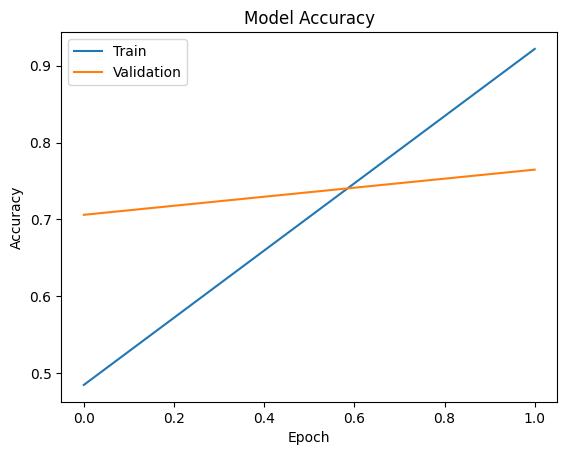

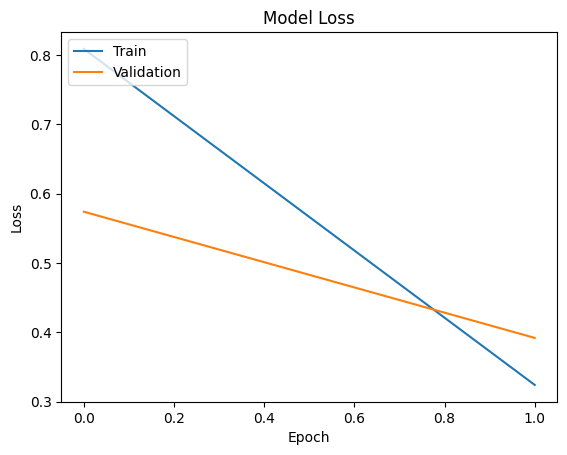

In [ ]:
import matplotlib.pyplot as plt

# 'history' is the object returned by the model.fit() method in TensorFlow

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate([X_test_ids, X_test_mask], y_test)

10/10 [==============================] - 2s 170ms/step - loss: 0.3588 - accuracy: 0.8304


[0.3587760031223297, 0.8304498195648193]

Let's take a quick look at false positives

In [ ]:
predictions = model.predict([X_test_ids, X_test_mask])
predicted_labels = (predictions > 0.5).astype('int32')
false_positives = np.where((predicted_labels == 1) & (y_test == 0))[0]

for index in false_positives[:10]:  # Top 10 false positives
    print(f"Index: {index}, Prediction: {predictions[index]}, Actual: {y_test[index]}")

2/2 [==============================] - 6s 2s/step
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0
Index: 0, Prediction: [0.84022903], Actual: 0


In [ ]:
import tensorflow
from tensorflow.keras.models import save_model

model.save_weights(f'../data/experiments/${EXPERIMENT_NAME}/checkpoints/segmented-selected')
save_model(model, f'../data/experiments/${EXPERIMENT_NAME}/model.h5')

In [ ]:
df_sf = df[(df['IsSelected'] == 0) & df['is_sf']]
df_sf = df_sf.dropna(subset=['body'])

df_sf['segmented_data'] = df_sf['body'].apply(segment_and_tokenize)
df_sf[['tokens', 'attention_mask']] = pd.DataFrame(df_sf['segmented_data'].tolist(), index=df_sf.index)

inference_X_ids = np.array(df_sf['tokens'].tolist())
inference_X_mask = np.array(df_sf['attention_mask'].tolist())


# Make predictions
predictions = model.predict([inference_X_ids, inference_X_mask])

# Get the top 100 results
top_1000_results = df_sf.iloc[predictions.argsort(axis=0)[-1000:].flatten()]
top_1000_results.to_csv(f'../data/experiments/${EXPERIMENT_NAME}/top_1000_results.csv', index=True)

3608/3608 [==============================] - 8970s 2s/step


In [ ]:
top_1000_results['FileName'].to_csv(f'../data/experiments/${EXPERIMENT_NAME}/top_1000_small_matched.txt', index=False, header=False)
SQL = """
DROP TABLE IF EXISTS DetectedBooks;

CREATE TABLE DetectedBooks (
    BookId INT NOT NULL,
    FileName VARCHAR(255) NOT NULL,
    Annotation VARCHAR(4096) NOT NULL,
    BookTitle VARCHAR(1024) NOT NULL,
    Authors VARCHAR(1024) NOT NULL,
    Genres VARCHAR(1024) NOT NULL
);


"""

def E(text):
    # Escaping single quotes
    text = text.replace("'", "\\'")
    # Escaping double quotes
    text = text.replace('"', '\\"')
    return text

for i, row in top_1000_results.iterrows():
  bookId = row['FileName'][:-4]
  SQL += "INSERT INTO DetectedBooks (BookId, FileName, Annotation, BookTitle, Authors, Genres) VALUES "
  SQL += f"({bookId}, '{row['FileName']}', '{E(row['Annotation'])}', '{E(row['BookTitle'])}', '{E(row['Authors'])}', '{row['Genres']}');\n"

SQL = SQL[:-2] + ';'
f = open(f'../data/experiments/${EXPERIMENT_NAME}/detected.sql', 'w')
f.write(SQL)

663491

In [ ]:
import mysql.connector
import db_config

# Connect to MySQL
cnx = mysql.connector.connect(
  host=db_config.DB_HOST,
  port=db_config.DB_PORT,
  user=db_config.DB_USER,
  password=db_config.DB_PASSWORD,
  database=db_config.DB_DATABASE,
)

cursor = cnx.cursor()
cursor.execute(SQL)